In [7]:
import numpy as np
from trained_untrained_results_funcs import find_best_layer, loop_through_datasets
from plotting_functions import plot_across_subjects
from matplotlib import pyplot as plt
import pandas as pdimport 
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/')
from banded_reg_func import himalaya_regression_caller

In [8]:
num_seeds = 5

In [9]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

subjects_storage = {}
network_labels_storage = {}

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    network_labels_storage[f"pereira{e}"]  = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_storage[f"pereira{e}"] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)

subjects_storage['fedorenko']  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_storage['blank'] = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

network_labels_storage['fedorenko'] = None
network_labels_storage['blank'] = None

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)

resultsPath_base = '/data/LLMs/brainscore/'
                    

#### The code block below does two things. 1st, it resaves the best layer of the untrained model so that I can run it again,
#### because I deleted the yhat values (due to storage space), and I need them now. Second, it stacks the best layer with the simple
#### feature spaces and saves that also.

In [10]:
SP_SL = np.load('/data/LLMs/data_processed/pereira/acts/X_positional_WN.npz')['layer1']
SP = np.load('/data/LLMs/data_processed/pereira/acts/X_positional_simple.npz')['layer1']
SL = np.load('/data/LLMs/data_processed/pereira/acts/X_word-num.npz')['layer1']

WP = np.load('/data/LLMs/data_processed/fedorenko/acts/X_soft+grow.npz')['layer1']

In [12]:
for d, fe, exp, subjects, networks in loop_through_datasets(dataset_arr=['pereira', 'fedorenko'], 
                            feature_extraction_arr=['', '-mp', '-sp'], subjects_dict=subjects_storage, 
                            networks_dict=network_labels_storage):
    
    print(d, fe, exp)
    
    if networks is not None:
        
        lang_indices = np.argwhere(networks=='language').squeeze()
    
    else:
        
        lang_indices = None
        
    save_acts = {}
    save_acts_stacked = {}
    
    if len(exp) > 0:
        exp = f'_{exp}'
        
    for i in range(num_seeds):
        
        # load activations
        X_untrained = np.load(f'/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}.npz')
        
        gpt2_untrained_dict, gpt2_untrained_bl, gpt2_untrained_bl_perf  = find_best_layer(np.arange(49), noL2_str='', exp=exp, 
                                                resultsPath=f"{resultsPath_base}results_{d}/untrained", 
                                                perf='out_of_sample_r2', feature_extraction=fe, selected_network_indices=lang_indices, 
                                                subjects=subjects, dataset=d, model_name='gpt2-xl-untrained', seed_number=i)
        
        X_best_layer = X_untrained[f'layer_{gpt2_untrained_bl}']
        
        if d == 'pereira':
            save_acts_stacked[f"m{i}_SP_SL_layer_{gpt2_untrained_bl}"] = np.hstack((X_best_layer, SP_SL))
            save_acts_stacked[f"m{i}_SL_layer_{gpt2_untrained_bl}"] = np.hstack((X_best_layer, SL))
            save_acts_stacked[f"m{i}_SP_layer_{gpt2_untrained_bl}"] = np.hstack((X_best_layer, SP))
        else:
            save_acts_stacked[f"m{i}_WP_layer_{gpt2_untrained_bl}"]  = np.hstack((X_best_layer, WP))
        
        save_acts[f"m{i}_layer_{gpt2_untrained_bl}"] = X_best_layer
        
    
    np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}-r2-best{exp}", **save_acts)
    np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}-var-par{exp}", **save_acts_stacked)
    

pereira  243
best layer:  3
best layer:  12
best layer:  45
best layer:  16
best layer:  5
pereira  384
best layer:  15
best layer:  12
best layer:  47
best layer:  48
best layer:  33
pereira -mp 243
best layer:  0
best layer:  0
best layer:  0
best layer:  0
best layer:  0
pereira -mp 384
best layer:  0
best layer:  0
best layer:  0
best layer:  0
best layer:  0
pereira -sp 243
best layer:  2
best layer:  1
best layer:  1
best layer:  1
best layer:  1
pereira -sp 384
best layer:  0
best layer:  0
best layer:  0
best layer:  0
best layer:  0
fedorenko  
(416, 1609)
best layer:  48
(416, 1609)
best layer:  23
(416, 1609)
best layer:  0
(416, 1609)
best layer:  5
(416, 1609)
best layer:  1
fedorenko -mp 
(416, 1609)
best layer:  3
(416, 1609)
best layer:  0
(416, 1609)
best layer:  0
(416, 1609)
best layer:  0
(416, 1609)
best layer:  0
fedorenko -sp 
(416, 1609)
best layer:  3
(416, 1609)
best layer:  19
(416, 1609)
best layer:  0
(416, 1609)
best layer:  0
(416, 1609)
best layer:  0


In [ ]:
np.load('f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}-r2-best{exp}"')

### Take the best layer of each untrained model based on out of sample R2, and stack the simple models.

In [ ]:

        


     
    for exp in exp_arr:

        
        




In [ ]:
plot_legend = False
palette = ['gray', 'blue', 'black']
perf_str=''
plot_xlabel = False
remove_y_axis = False
num_seeds = 5
dataset_arr = ['pereira', 'fedorenko']
feature_extraction_arr = ['', '-mp', '-sp']
perf_arr = ['pearson_r', 'out_of_sample_r2']
shuffled_arr = ['']

save_best_layer = []




for dnum, d in enumerate(dataset_arr):
    
    results_dict_gpt2_untrained = {'perf':[], 'subjects': [], 'Network': [], 
                                'Model': []}
    
    results_dict_gpt2 = {'perf':[], 'subjects': [], 'Network': [], 
                                'Model': []}
    
    if d == 'pereira':
        results_dict_gpt2_untrained['Exp'] = []
    
    
    if d == 'pereira':
        exp_arr = ['384', '243']
    else:
        
        exp_arr = ['']
    
        if d == 'fedorenko':
            subjects_arr = subjects_arr_fed
        if d == 'blank':
            subjects_arr = subjects_arr_blank
                
        networks_arr = np.repeat('language', len(subjects_arr))
        
                        
    for fe in feature_extraction_arr:
        
    
        for exp in exp_arr:
            
            if len(exp) > 0:
                selected_lang_indices = lang_indices_dict[exp]
                subjects_arr = subjects_dict[exp]
                networks_arr = br_labels_dict[exp]
                exp = f"_{exp}"
                
            else:
                selected_lang_indices = None

            for i in range(num_seeds):
                
                gpt2_untrained_acts = np.load(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}.npz")
                            

                gpt2_untrained_dict, gpt2_untrained_bl, gpt2_untrained_bl_perf  = find_best_layer(np.arange(49), noL2_str='', exp=exp, 
                                                            resultsPath=f"{resultsPath_base}results_{d}/untrained/", 
                                                            perf='out_of_sample_r2', feature_extraction=fe, selected_network_indices=selected_lang_indices, 
                                                            subjects=subjects_arr, dataset=d, model_name='gpt2-xl-untrained', seed_number=i)
                
                best_layer = max(gpt2_untrained_dict, key=gpt2_untrained_dict.get)
                save_best_layer.append(f"{d}_gpt2-xl-untrained{fe}_m{i}_layer_{best_layer}_1{exp}.npz") 
                
                gpt2_best_acts = gpt2_untrained_acts[f'layer_{best_layer}']
                
                if d == 'pereira':
                    banded_model = np.hstack((gpt2_best_acts, SP_SL))
                    np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}_SP+SL", **{'layer1':banded_model})
                    
                elif d == 'fedorenko':
                    banded_model = np.hstack((gpt2_best_acts, WP))
                    np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}_soft+grow", **{'layer1':banded_model})
                    
                results_dict_gpt2_untrained['perf'].extend(gpt2_untrained_bl_perf)
                results_dict_gpt2_untrained['subjects'].extend(subjects_arr)
                results_dict_gpt2_untrained['Network'].extend(networks_arr)
                results_dict_gpt2_untrained['Model'].extend(np.repeat(f'GPT2XLU{fe}', len(gpt2_untrained_bl_perf)))
                if d == 'pereira':
                    results_dict_gpt2_untrained['Exp'].extend(np.repeat(exp.strip('_'), num_vox_dict[exp.strip('_')]))
            
    results_dict_gpt2_untrained = pd.DataFrame(results_dict_gpt2_untrained)
    results_dict_gpt2 = pd.DataFrame(results_dict_gpt2)
    
    results_dict_gpt2_combined = pd.concat((results_dict_gpt2, results_dict_gpt2_untrained))
    
    
    if len(dataset_arr) == 1:
        ax_select = ax
    else:
        ax_select = ax[dnum]
    
    subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_dict_gpt2_untrained.copy(), figurePath=figurePath,  selected_networks=['language'],
                                                        dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                        draw_lines=False, ms=15, plot_legend=False,  
                                                        plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax_select,
                                                        remove_yaxis=remove_y_axis, plot_xlabel=plot_xlabel, alpha=0.5)
plt.show()

In [14]:
dataset_arr = ['pereira', 'fedorenko']
feature_extraction_arr = ['', '-mp', '-sp']
perf_arr = ['out_of_sample_r2']

In [15]:
resultsPath_base = '/data/LLMs/brainscore/'
figurePath = 'figures/new_figures/figure5/'

In [19]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()
lang_indices_dict = {}
lang_indices_dict['384'] = lang_indices_384
lang_indices_dict['243'] = lang_indices_243

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
                    


pearson_r
Taking median value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Taking median value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


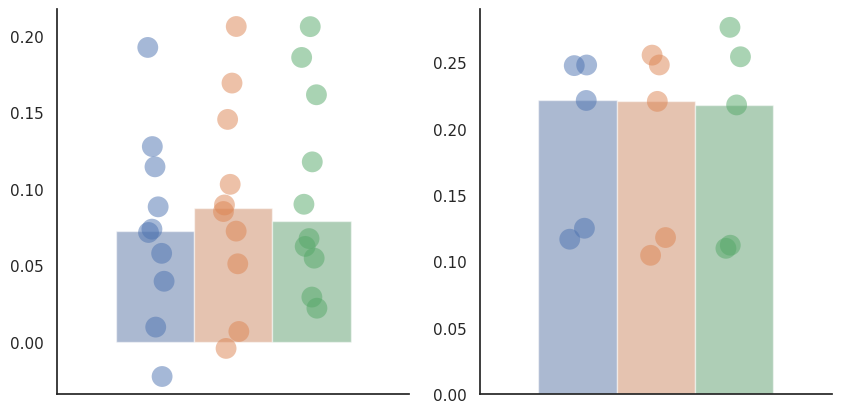

out_of_sample_r2
Clipping 0 values
Taking mean value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipping 0 values
Taking mean value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


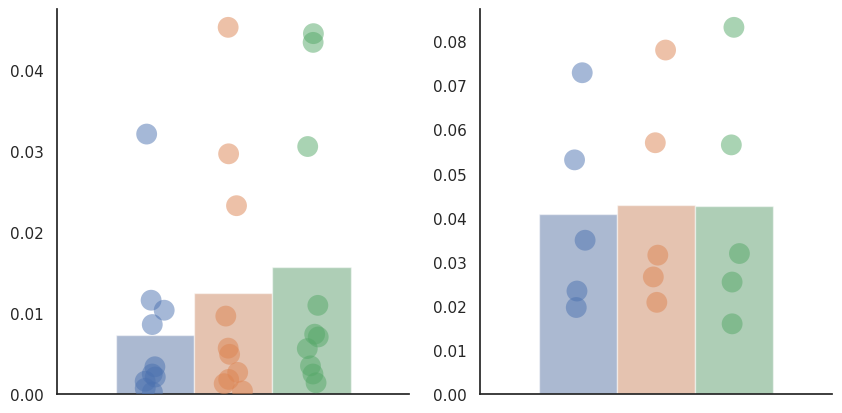

In [18]:
plot_legend = False
palette = ['gray', 'blue', 'black']
perf_str=''
plot_xlabel=False
remove_y_axis = False
num_seeds = 5
dataset_arr = ['pereira', 'fedorenko']
feature_extraction_arr = ['', '-mp', '-sp']
perf_arr = ['pearson_r', 'out_of_sample_r2']
shuffled_arr = ['']

save_best_layer = []

for shuffled in shuffled_arr:

    for perf in perf_arr:
                    
        if perf == 'pearson_r':
            clip_zero = False
            median = True
        else:
            clip_zero = True
            median = False
            
        fig, ax = plt.subplots(1, len(dataset_arr), figsize=(10,5))
                
        for dnum, d in enumerate(dataset_arr):
            
            results_dict_gpt2_untrained = {'perf':[], 'subjects': [], 'Network': [], 
                                        'Model': []}
            
            results_dict_gpt2 = {'perf':[], 'subjects': [], 'Network': [], 
                                        'Model': []}
            
            if d == 'pereira':
                results_dict_gpt2_untrained['Exp'] = []
            
            
            if d == 'pereira':
                exp_arr = ['384', '243']
            else:
                
                exp_arr = ['']
            
                if d == 'fedorenko':
                    subjects_arr = subjects_arr_fed
                if d == 'blank':
                    subjects_arr = subjects_arr_blank
                        
                networks_arr = np.repeat('language', len(subjects_arr))
                
                                
            for fe in feature_extraction_arr:
                
            
                for exp in exp_arr:
                    
                    if len(exp) > 0:
                        selected_lang_indices = lang_indices_dict[exp]
                        subjects_arr = subjects_dict[exp]
                        networks_arr = br_labels_dict[exp]
                        exp = f"_{exp}"
                        
                    else:
                        selected_lang_indices = None
                    
                    gpt2_dict, gpt2_bl, gpt2_bl_perf  = find_best_layer(np.arange(49), noL2_str='', exp=exp, 
                                                                resultsPath=f"{resultsPath_base}results_{d}/{shuffled}", 
                                                                perf=perf, feature_extraction=fe, selected_network_indices=selected_lang_indices, 
                                                                subjects=subjects_arr, dataset=d, model_name='gpt2-xl')
                    
                    results_dict_gpt2['perf'].extend(gpt2_bl_perf)
                    results_dict_gpt2['subjects'].extend(subjects_arr)
                    results_dict_gpt2['Network'].extend(networks_arr)
                    results_dict_gpt2['Model'].extend(np.repeat(f'GPT2XL{fe}', len(gpt2_bl_perf)))
                    
                    for i in range(num_seeds):
                        
                        gpt2_untrained_acts = np.load(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}.npz")
                                    
    
                        gpt2_untrained_dict, gpt2_untrained_bl, gpt2_untrained_bl_perf  = find_best_layer(np.arange(49), noL2_str='', exp=exp, 
                                                                    resultsPath=f"{resultsPath_base}results_{d}/untrained/{shuffled}", 
                                                                    perf=perf, feature_extraction=fe, selected_network_indices=selected_lang_indices, 
                                                                    subjects=subjects_arr, dataset=d, model_name='gpt2-xl-untrained', seed_number=i)
                        
                        best_layer = max(gpt2_untrained_dict, key=gpt2_untrained_dict.get)
                        save_best_layer.append(f"{d}_gpt2-xl-untrained{fe}_m{i}_layer_{best_layer}_1{exp}.npz") 
                        
                        
                        gpt2_best_acts = gpt2_untrained_acts[f'layer_{best_layer}']
                        
                        if d == 'pereira':
                            banded_model = np.hstack((gpt2_best_acts, SP_SL))
                            np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}_SP+SL", **{'layer1':banded_model})
                            
                        elif d == 'fedorenko':
                            banded_model = np.hstack((gpt2_best_acts, WP))
                            np.savez(f"/data/LLMs/data_processed/{d}/acts/X_gpt2-xl-untrained{fe}_m{i}_soft+grow", **{'layer1':banded_model})
                            
                        results_dict_gpt2_untrained['perf'].extend(gpt2_untrained_bl_perf)
                        results_dict_gpt2_untrained['subjects'].extend(subjects_arr)
                        results_dict_gpt2_untrained['Network'].extend(networks_arr)
                        results_dict_gpt2_untrained['Model'].extend(np.repeat(f'GPT2XLU{fe}', len(gpt2_untrained_bl_perf)))
                        if d == 'pereira':
                            results_dict_gpt2_untrained['Exp'].extend(np.repeat(exp.strip('_'), num_vox_dict[exp.strip('_')]))
                    
            results_dict_gpt2_untrained = pd.DataFrame(results_dict_gpt2_untrained)
            results_dict_gpt2 = pd.DataFrame(results_dict_gpt2)
            
            results_dict_gpt2_combined = pd.concat((results_dict_gpt2, results_dict_gpt2_untrained))
            
            
            if len(dataset_arr) == 1:
                ax_select = ax
            else:
                ax_select = ax[dnum]
            
            subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_dict_gpt2_untrained.copy(), figurePath=figurePath,  selected_networks=['language'],
                                                                dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                                draw_lines=False, ms=15, plot_legend=False,  
                                                                plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax_select,
                                                                remove_yaxis=remove_y_axis, plot_xlabel=plot_xlabel, alpha=0.5)
        plt.show()

In [17]:
for file in save_best_layer:
    if 'pereira' in file:
        print(file)

pereira_gpt2-xl-untrained_m0_layer_47_1_384.npz
pereira_gpt2-xl-untrained_m1_layer_21_1_384.npz
pereira_gpt2-xl-untrained_m2_layer_36_1_384.npz
pereira_gpt2-xl-untrained_m3_layer_48_1_384.npz
pereira_gpt2-xl-untrained_m4_layer_37_1_384.npz
pereira_gpt2-xl-untrained_m0_layer_3_1_243.npz
pereira_gpt2-xl-untrained_m1_layer_1_1_243.npz
pereira_gpt2-xl-untrained_m2_layer_2_1_243.npz
pereira_gpt2-xl-untrained_m3_layer_13_1_243.npz
pereira_gpt2-xl-untrained_m4_layer_5_1_243.npz
pereira_gpt2-xl-untrained-mp_m0_layer_2_1_384.npz
pereira_gpt2-xl-untrained-mp_m1_layer_3_1_384.npz
pereira_gpt2-xl-untrained-mp_m2_layer_47_1_384.npz
pereira_gpt2-xl-untrained-mp_m3_layer_5_1_384.npz
pereira_gpt2-xl-untrained-mp_m4_layer_3_1_384.npz
pereira_gpt2-xl-untrained-mp_m0_layer_0_1_243.npz
pereira_gpt2-xl-untrained-mp_m1_layer_0_1_243.npz
pereira_gpt2-xl-untrained-mp_m2_layer_0_1_243.npz
pereira_gpt2-xl-untrained-mp_m3_layer_0_1_243.npz
pereira_gpt2-xl-untrained-mp_m4_layer_0_1_243.npz
pereira_gpt2-xl-untrain

In [14]:
import os
clean_y_hat = True
dataset_arr = ['blank']
if clean_y_hat:
    for shuffled  in shuffled_arr:
        for d in dataset_arr:
        
            for file in os.listdir(f"{resultsPath_base}results_{d}/untrained/{shuffled}"):
                
                if file in save_best_layer:
                    continue
                
                else:
                    file_path = os.path.join(f"{resultsPath_base}results_{d}/untrained/{shuffled}", file)
                    
                    if 'gpt2-xl' in file_path:
                        
                        # Load the .npz file
                        data = np.load(file_path, allow_pickle=True)
                        data_dict = {key: data[key] for key in data.files if key != 'y_hat'}
                        
                        # Resave the modified data
                        np.savez(file_path, **data_dict)
                        print(f"Processed and resaved {file} without the 'y_hat' key")

Processed and resaved blank_gpt2-xl-untrained-mp_m4_layer_11_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-sp_m0_layer_13_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-sp_m1_layer_8_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained_m1_layer_26_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained_m3_layer_14_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained_m1_layer_39_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-sp_m2_layer_3_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-sp_m2_layer_38_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-mp_m2_layer_10_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-mp_m4_layer_1_1.npz without the 'y_hat' key
Processed and resaved blank_gpt2-xl-untrained-sp_m1_layer_33_1.npz without the 'y_hat' key
Processed a